In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from tensorflow.keras import layers
import tensorflow_hub as hub 
sns.set_style('darkgrid')

2025-01-26 23:20:41.686047: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 23:20:41.694187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737926441.702822  878385 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737926441.705339  878385 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 23:20:41.714512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
data_dir = "/mnt/c//Users/iosif/Desktop/Python/Tensorflow/Disaster Tweets"
#-------------------------------------------------------------------------
train_data = pd.read_csv("/mnt/c//Users/iosif/Desktop/Python/Tensorflow/Disaster Tweets/train.csv")
test_data = pd.read_csv("/mnt/c//Users/iosif/Desktop/Python/Tensorflow/Disaster Tweets/test.csv")

In [7]:
from sklearn.model_selection import train_test_split

train_text, val_text, train_labels, val_labels = train_test_split(train_data["text"].to_numpy(),
                                                                  train_data["target"].to_numpy(),
                                                                  test_size=0.1,
                                                                  )
#-------------------------------------------------------------------------
len(train_text), len(val_text), len(train_labels), len(val_labels) 

(6851, 762, 6851, 762)

In [8]:
length = []
for i in train_text:
    length.append(len(i.split()))
    
average_tweet_length = round(sum(length)/ len(length))
maximum_tweet_length = max(length)

In [9]:
text_vectorizer = tf.keras.layers.TextVectorization(output_mode="int",
                                                    output_sequence_length=average_tweet_length,
                                                    max_tokens=10000)

# Produce a vocabulary of 10.000 words
text_vectorizer.adapt(train_text)

# Create an Embeding layer
embeding = tf.keras.layers.Embedding(input_dim=maximum_tweet_length,
                                     output_dim=128)

I0000 00:00:1737926444.525293  878385 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


# Sklearn method

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# Create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),   # words to numbers
    ("clf", MultinomialNB())        # model the text
])

model_0.fit(train_text, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

<Axes: >

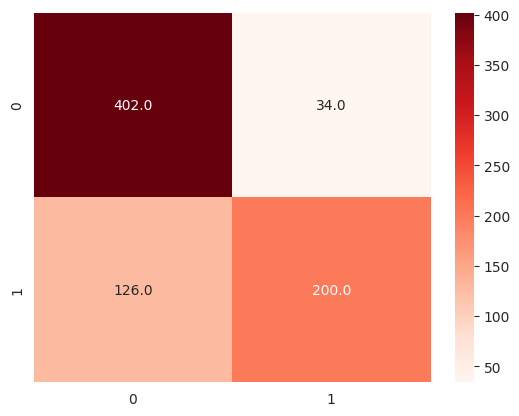

In [11]:
# Evaluate
baseline_score = model_0.score(X=val_text, y=val_labels)

baseline_preds = model_0.predict(val_text)
cm = confusion_matrix(y_pred=baseline_preds,
                      y_true=val_labels)

sns.heatmap(cm, cmap="Reds", annot=True, yticklabels=True,fmt=".1f")

# Tensorflow method

In [44]:
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)  # input text is one-dimentional
x = text_vectorizer(inputs)                                 # input text into numbers
x = embeding(x)                                             # numbers into an embeding
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # output layer
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

hist_1 = model_1.fit(x=train_text,
                     y=train_labels,
                     epochs=5,
                     validation_data=(val_text, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5878 - loss: 0.6714 - val_accuracy: 0.6601 - val_loss: 0.6327
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6564 - loss: 0.6298 - val_accuracy: 0.6562 - val_loss: 0.6129
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6616 - loss: 0.6128 - val_accuracy: 0.6601 - val_loss: 0.6102
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6640 - loss: 0.6067 - val_accuracy: 0.6627 - val_loss: 0.6099
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6516 - loss: 0.6122 - val_accuracy: 0.6627 - val_loss: 0.6097


In [9]:
model_1.evaluate(val_text, val_labels) 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6561 - loss: 0.6335


[0.6322870254516602, 0.6640419960021973]

In [10]:
predictions = model_1.predict(val_text)
predictions = tf.squeeze(tf.round(predictions))
predictions

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1

In [11]:
cmt = confusion_matrix(y_pred=predictions,
                       y_true=val_labels)

<Axes: >

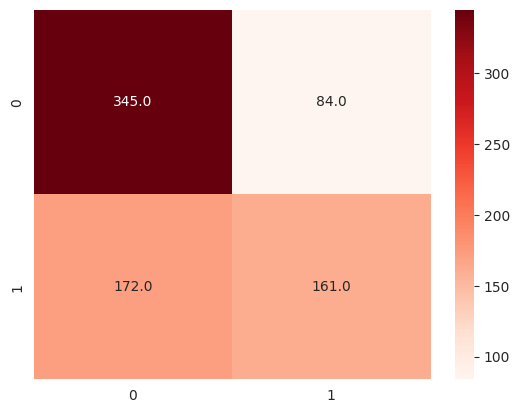

In [12]:
sns.heatmap(cmt, cmap="Reds", annot=True, fmt=".1f")

In [13]:
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab

['',
 '[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('in'),
 np.str_('to'),
 np.str_('of'),
 np.str_('and'),
 np.str_('i'),
 np.str_('is'),
 np.str_('for'),
 np.str_('on'),
 np.str_('you'),
 np.str_('my'),
 np.str_('with'),
 np.str_('that'),
 np.str_('it'),
 np.str_('at'),
 np.str_('by'),
 np.str_('this'),
 np.str_('from'),
 np.str_('be'),
 np.str_('are'),
 np.str_('was'),
 np.str_('have'),
 np.str_('like'),
 np.str_('as'),
 np.str_('me'),
 np.str_('up'),
 np.str_('but'),
 np.str_('just'),
 np.str_('so'),
 np.str_('amp'),
 np.str_('im'),
 np.str_('not'),
 np.str_('your'),
 np.str_('out'),
 np.str_('its'),
 np.str_('after'),
 np.str_('will'),
 np.str_('all'),
 np.str_('fire'),
 np.str_('no'),
 np.str_('has'),
 np.str_('an'),
 np.str_('if'),
 np.str_('when'),
 np.str_('get'),
 np.str_('new'),
 np.str_('we'),
 np.str_('via'),
 np.str_('now'),
 np.str_('about'),
 np.str_('or'),
 np.str_('more'),
 np.str_('people'),
 np.str_('what'),
 np.str_('news'),
 np.str_('been'),
 np.str_('he'),
 n

In [14]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,293 (48.02 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,196 (32.02 KB)

In [15]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(31, 128)

# RNN

In [16]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embeding(x)
x = layers.LSTM(units=64, return_sequences=True)(x)
x = layers.LSTM(units=64)(x)
x = layers.Dense(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

hist_2 = model_2.fit(epochs=15,
                     x=train_text,
                     y=train_labels,
                     validation_data=(val_text, val_labels))

Epoch 1/15
  9/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5186 - loss: 0.6864

I0000 00:00:1737919325.186048  849623 cuda_dnn.cc:529] Loaded cuDNN version 90300


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6397 - loss: 0.6297 - val_accuracy: 0.6509 - val_loss: 0.6530
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6615 - loss: 0.6163 - val_accuracy: 0.6654 - val_loss: 0.6209
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6667 - loss: 0.6045 - val_accuracy: 0.6575 - val_loss: 0.6315
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6727 - loss: 0.6047 - val_accuracy: 0.6745 - val_loss: 0.6266
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6697 - loss: 0.6070 - val_accuracy: 0.6732 - val_loss: 0.6205
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6700 - loss: 0.6006 - val_accuracy: 0.6654 - val_loss: 0.6189
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6783 - loss: 0.5980 - val_accuracy: 0.6759 - val_loss: 0.6342
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6902 - loss: 0.5819 - val_accuracy: 0.6706 

# GRU

In [17]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embeding(x)
x = layers.GRU(units=64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(units=64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_3.fit(epochs=15,
            x=train_text,
            y=train_labels,
            validation_data=(val_text, val_labels))

Epoch 1/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6521 - loss: 0.6300 - val_accuracy: 0.6798 - val_loss: 0.6266
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6644 - loss: 0.6129 - val_accuracy: 0.6719 - val_loss: 0.6153
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6871 - loss: 0.5923 - val_accuracy: 0.6837 - val_loss: 0.6043
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6890 - loss: 0.5866 - val_accuracy: 0.6627 - val_loss: 0.6186
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6846 - loss: 0.5878 - val_accuracy: 0.6614 - val_loss: 0.6088
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6875 - loss: 0.5829 - val_accuracy: 0.6785 - val_loss: 0.6140
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7056 - loss: 0.5685 - val_accuracy: 0.6706 - val_loss: 0.6238
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6956 - loss: 0.5708 - val_accu

# Bidirectional

In [18]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embeding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs)

model_4.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_4.fit(epochs=15,
            x=train_text,
            y=train_labels,
            validation_data=(val_text, val_labels))

Epoch 1/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6555 - loss: 0.6164 - val_accuracy: 0.6732 - val_loss: 0.6239
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6726 - loss: 0.5941 - val_accuracy: 0.6693 - val_loss: 0.6230
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6939 - loss: 0.5818 - val_accuracy: 0.6549 - val_loss: 0.6204
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6884 - loss: 0.5833 - val_accuracy: 0.6286 - val_loss: 0.6255
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6937 - loss: 0.5780 - val_accuracy: 0.6654 - val_loss: 0.6236
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6988 - loss: 0.5699 - val_accuracy: 0.6575 - val_loss: 0.6179
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6989 - loss: 0.5656 - val_accuracy: 0.6667 - val_loss: 0.6129
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6925 - loss: 0.5640 - val_accu

# Conv1D

In [19]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embeding(x)
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="valid", strides=1)(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_5.fit(x=train_text,
            y=train_labels,
            epochs=15,
            validation_data=(val_text, val_labels))

Epoch 1/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6649 - loss: 0.6164 - val_accuracy: 0.6864 - val_loss: 0.6160
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6857 - loss: 0.5877 - val_accuracy: 0.6614 - val_loss: 0.6081
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6978 - loss: 0.5743 - val_accuracy: 0.6706 - val_loss: 0.6092
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7140 - loss: 0.5504 - val_accuracy: 0.6614 - val_loss: 0.5986
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7210 - loss: 0.5476 - val_accuracy: 0.6640 - val_loss: 0.6025
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7345 - loss: 0.5323 - val_accuracy: 0.6470 - val_loss: 0.6062
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7428 - loss: 0.5233 - val_accuracy: 0.6575 - val_loss: 0.6222
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7433 - loss: 0.5168 - val_accuracy: 0.

# Sequential

In [57]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
sequences = tokenizer.texts_to_sequences(train_text)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=15)

train_labels_rs = tf.expand_dims(train_labels, axis=-1)
#----------------
val_sequences = tokenizer.texts_to_sequences(val_text)
val_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=15)

model_6 = tf.keras.Sequential([
    layers.Embedding(input_dim=5000,output_dim=128),
    layers.LSTM(units=64,return_sequences=False),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model_6.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_6.fit(epochs=10,
            x=padded_sequences,
            y=train_labels,
            validation_data=(val_padded_sequences, val_labels))

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6698 - loss: 0.5945 - val_accuracy: 0.7835 - val_loss: 0.4826
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8521 - loss: 0.3514 - val_accuracy: 0.7795 - val_loss: 0.4622
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9020 - loss: 0.2604 - val_accuracy: 0.7730 - val_loss: 0.5479
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9341 - loss: 0.1806 - val_accuracy: 0.7598 - val_loss: 0.6679
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9536 - loss: 0.1261 - val_accuracy: 0.7520 - val_loss: 0.8168
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9586 - loss: 0.1009 - val_accuracy: 0.7546 - val_loss: 0.9051
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9655 - loss: 0.0739 - val_accuracy: 0.7559 - val_loss: 1.1482
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9648 - loss: 0.0730 - val_accuracy: 0.

In [58]:
def predictions(text):
    new_text= [f"{text}"]
    new_sequences = tokenizer.texts_to_sequences(new_text)  # Convert text to sequences
    new_padded = tf.keras.preprocessing.sequence.pad_sequences(new_sequences, maxlen=10)
    predictions = model_6.predict(new_padded)  # Predict on the padded sequence
    predicted_labels = (predictions > 0.5).astype(int)

    print(f"Text: {new_text[0]}")
    print(f"Prediction (Probability): {predictions[0][0]:.2f}")
    print(f"Predicted Label: {'Positive' if predicted_labels[0][0] == 1 else 'Negative'}")
    return predictions


In [59]:
predictions("The first argument to the plotly.graph_objs.Scatter3d constructor must be a dict or")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Text: The first argument to the plotly.graph_objs.Scatter3d constructor must be a dict or
Prediction (Probability): 0.03
Predicted Label: Negative


array([[0.0261613]], dtype=float32)